In [1]:
#Importing necessary libraries
# data analysis/visualisation stack
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# statistics stack
from scipy import stats
# Importing required libraries
import requests

import csv


# machine learning stack
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import silhouette_score

import warnings
warnings.simplefilter('ignore')

In [2]:
#timeseries

from itertools import permutations

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [4]:
#import the data from a csv-file
df_sales= pd.read_csv('data/prog_customer.csv')
df_afo=pd.read_csv('data/prog_afo.csv')

In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            117 non-null    object 
 1   year             117 non-null    float64
 2   monthly_revenue  117 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.9+ KB


In [6]:
df_sales["year"] = df_sales["year"].astype(int)

In [7]:
df_sales.isna().sum() #no missing value

month              0
year               0
monthly_revenue    0
dtype: int64

<Axes: ylabel='monthly_revenue'>

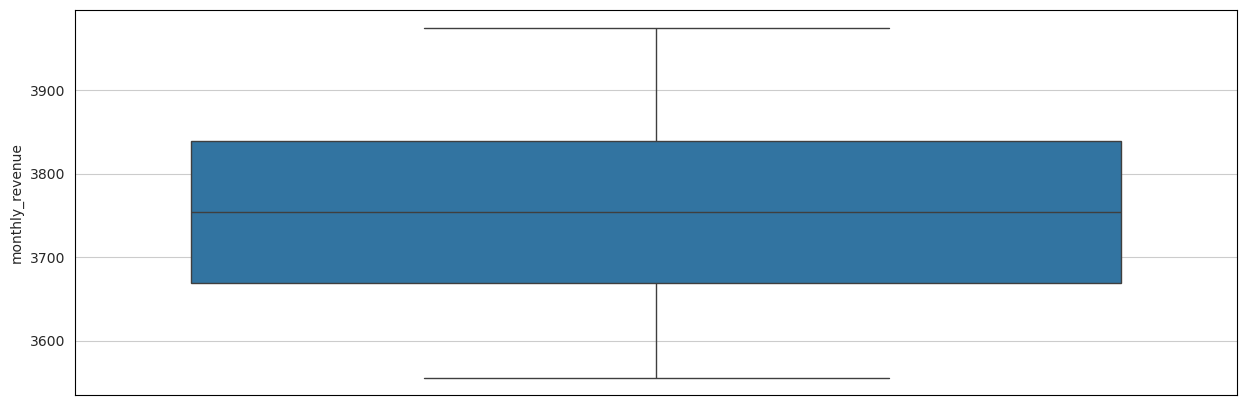

In [8]:
#distribution of revenues
sns.boxplot(data=df_sales, y='monthly_revenue') #mean and median seems at the same level.

In [9]:
df_sales.describe()

,year,monthly_revenue
count,117.000,117.000
mean,2009.872,3754.872
std,2.851,104.187
min,2005.000,3556.000
25%,2007.000,3669.000
50%,2010.000,3754.000
75%,2012.000,3839.000
max,2015.000,3975.000


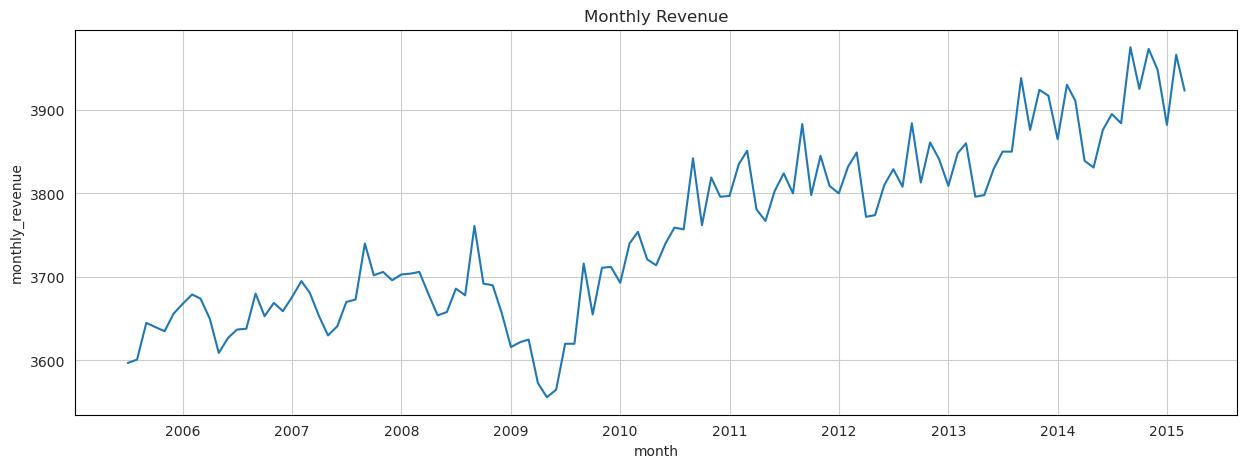

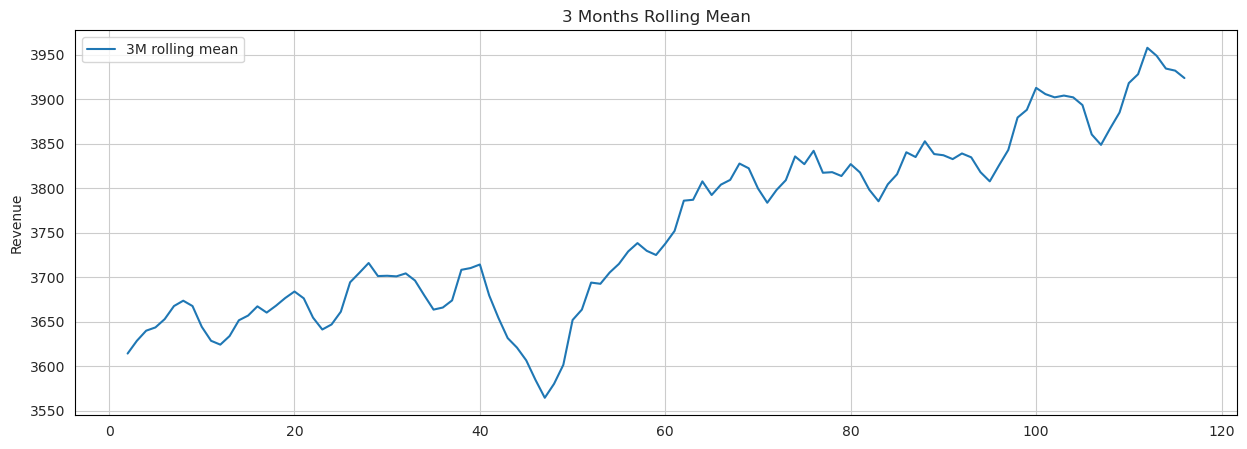

In [50]:
sns.lineplot(data=df_sales, x='month', y='monthly_revenue')

plt.title("Monthly Revenue")
#plt.xlabel("Month")
#plt.ylabel("Revenue")
plt.savefig("visualisations/monthly_rev.png", dpi=300)
plt.show()

df_sales['monthly_revenue'].rolling(3).mean().plot(label="3M rolling mean")
plt.title("3 Months Rolling Mean")
#plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.savefig("visualisations/monthly_rev_3mrollingaverage.png", dpi=300)
plt.show()


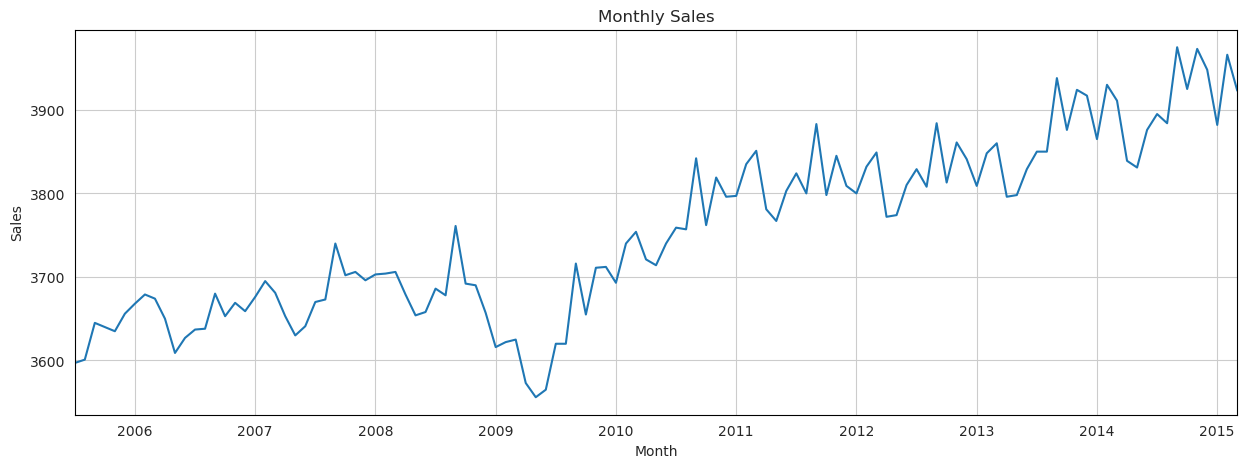

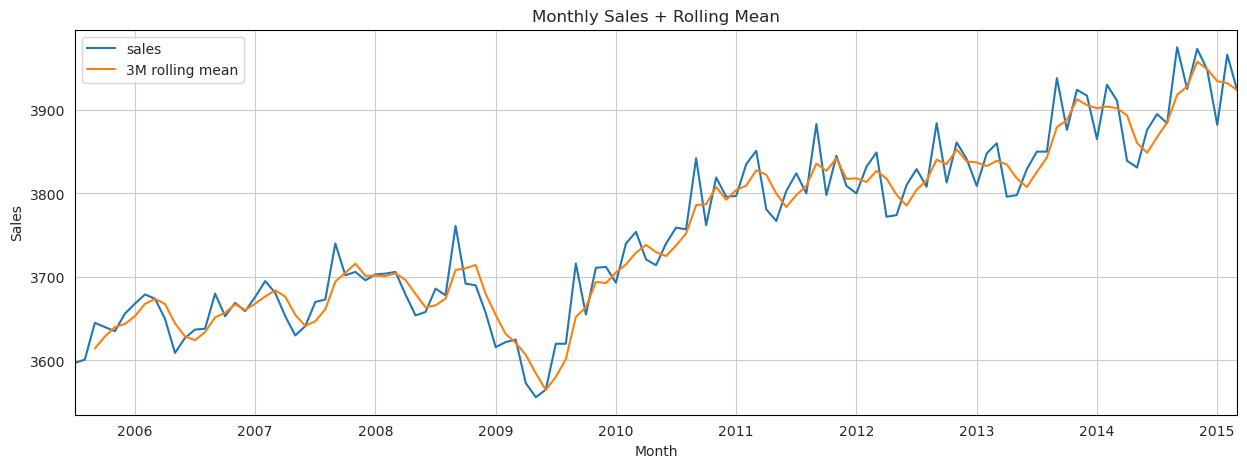

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure types + sorting
df_sales["month"] = pd.to_datetime(df_sales["month"])
df_sales = df_sales.sort_values("month")

# Make a monthly time series
ts = df_sales.set_index("month")["monthly_revenue"].asfreq("MS")

plt.figure()
ts.plot()
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

# Optional: rolling mean (trend view)
plt.figure()
ts.plot(label="sales")
ts.rolling(3).mean().plot(label="3M rolling mean")
plt.title("Monthly Revenue + Rolling Mean")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.show()


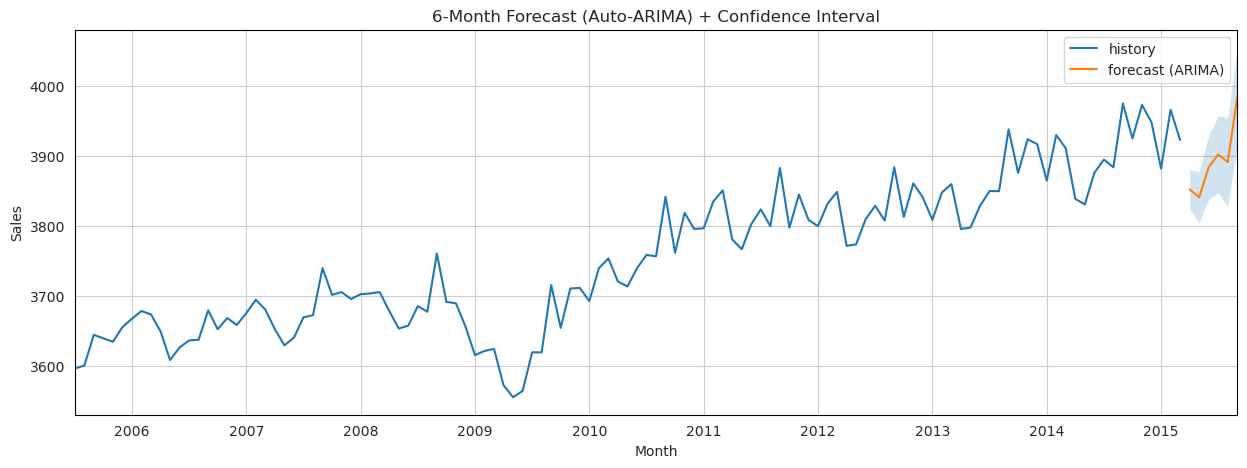

In [12]:

import pmdarima as pm
import numpy as np

h = 6
model = pm.auto_arima(
    ts,
    seasonal=True,
    m=12,                 # monthly seasonality
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore"
)

fc, confint = model.predict(n_periods=h, return_conf_int=True)
future_idx = pd.date_range(ts.index[-1] + pd.offsets.MonthBegin(1), periods=h, freq="MS")

fc = pd.Series(fc, index=future_idx)
lower = pd.Series(confint[:, 0], index=future_idx)
upper = pd.Series(confint[:, 1], index=future_idx)

plt.figure()
ts.plot(label="history")
fc.plot(label="forecast (ARIMA)")
plt.fill_between(future_idx, lower, upper, alpha=0.2)
plt.title("6-Month Forecast (Auto-ARIMA) + Confidence Interval")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()


## Decomposition

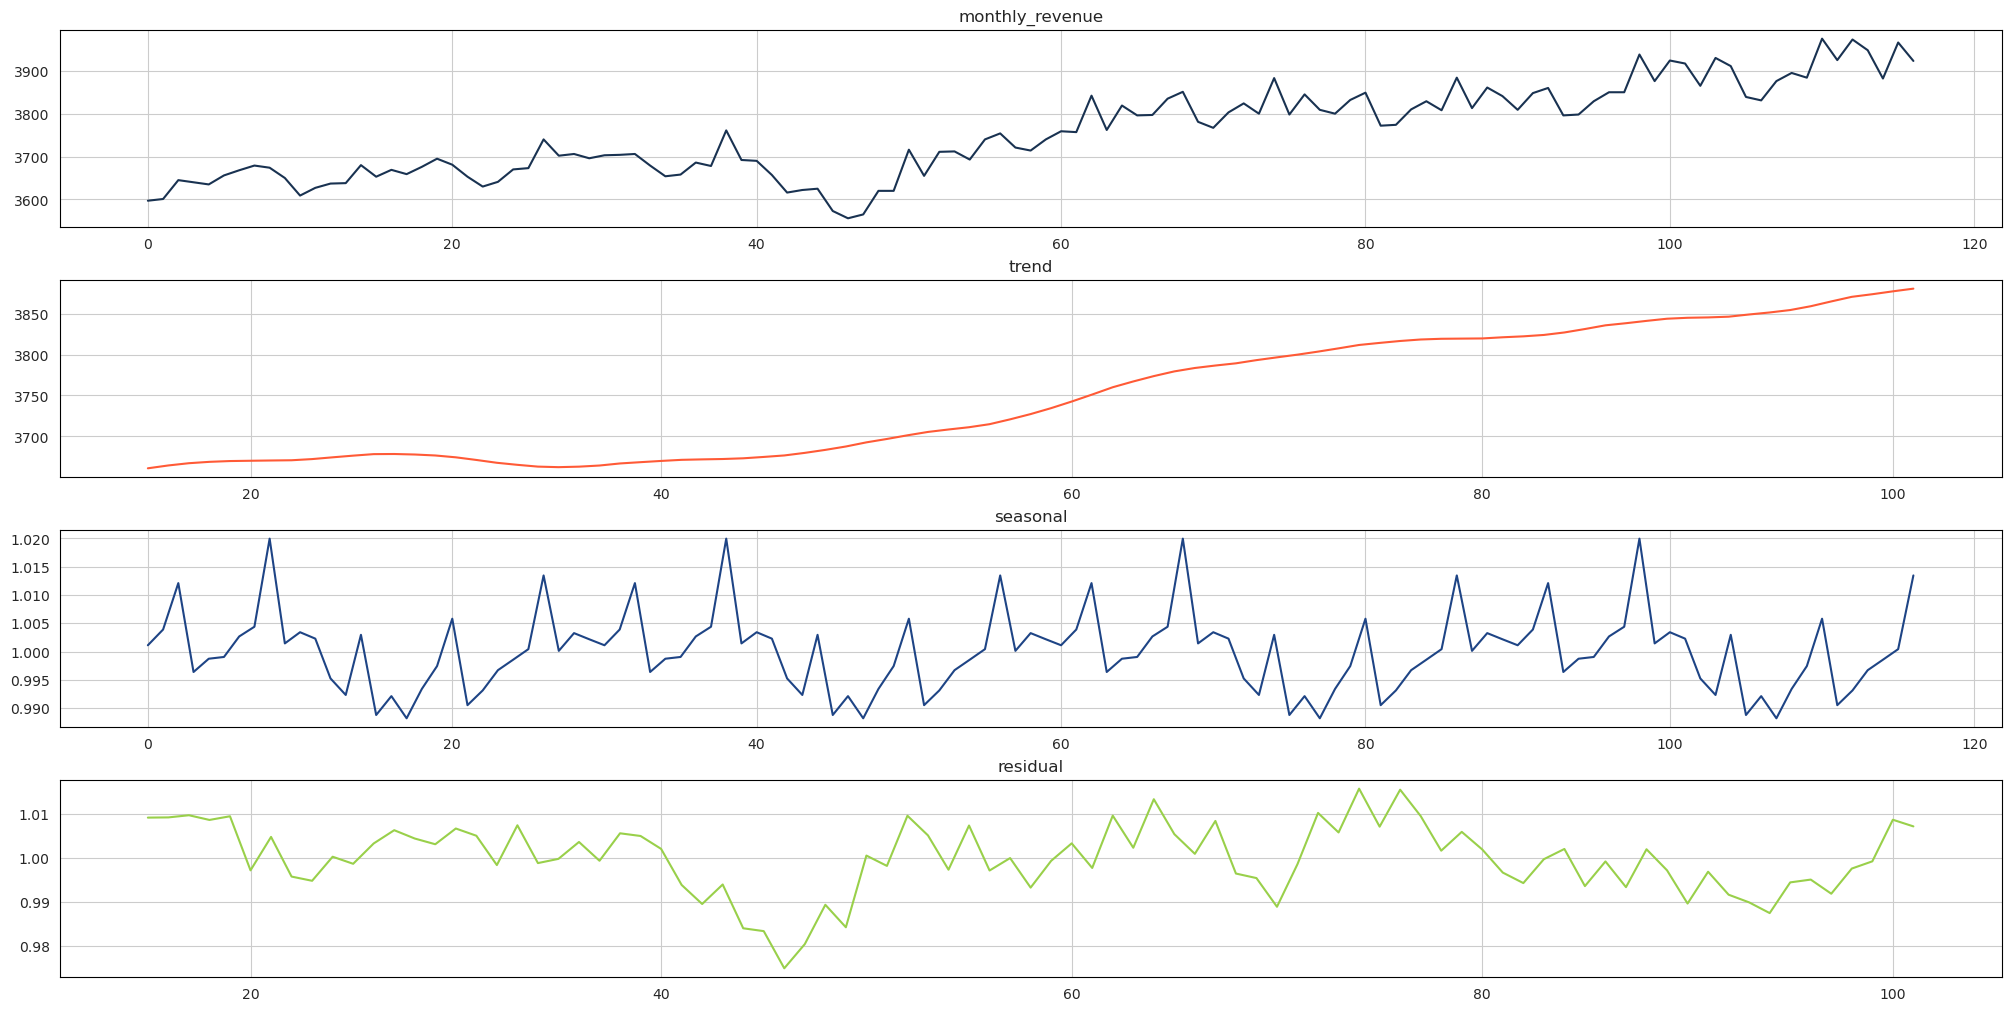

In [44]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df_sales['monthly_revenue'], 
                                   model='multiplicative',
                                   period=30)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='monthly_revenue')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);
plt.savefig("visualisations/series_trend_seasonality_residual.png", dpi=300)

## Decomposition shows: 
* Clear upward trend over time

* Strong seasonality

* Variability increases slightly over time
==> Both trend + seasonality present


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.372082
p-value: 0.595585
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.870470
p-value: 0.010000
----------------------------------------


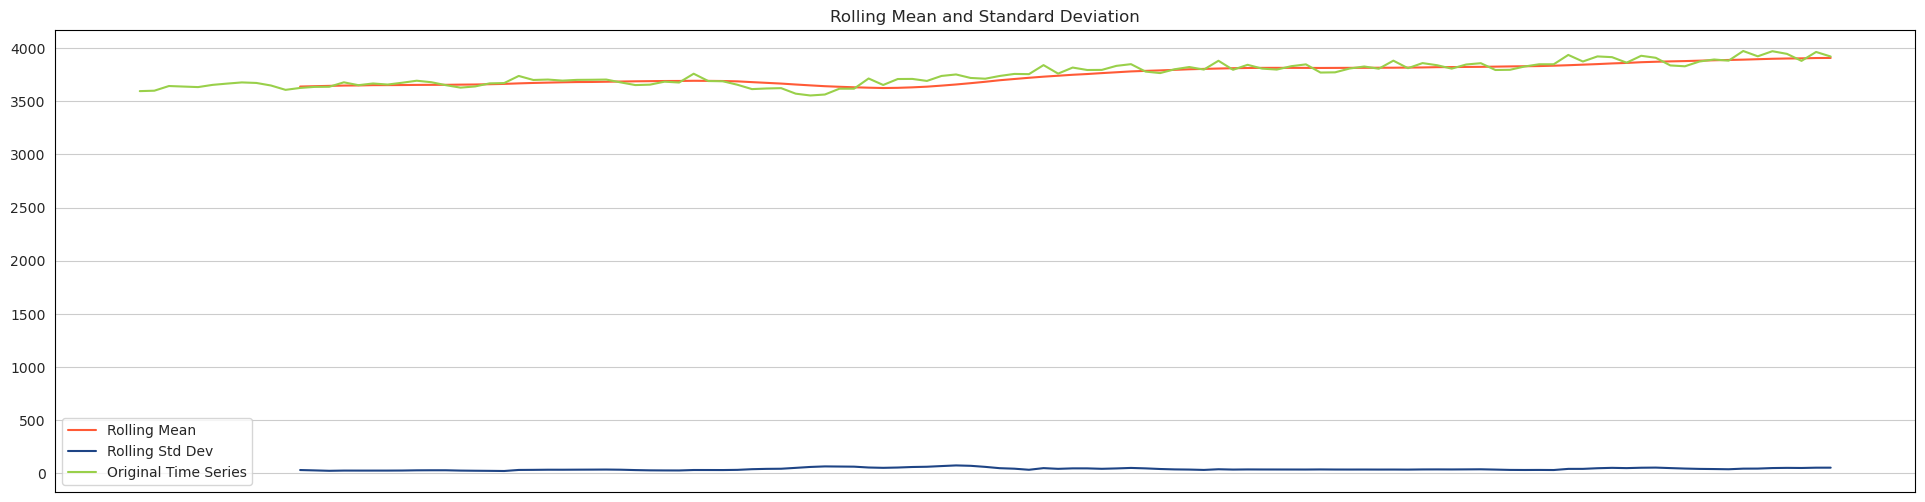

In [26]:
# Test for stationarity 

def stationarity_test(monthly_revenue):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = monthly_revenue.rolling(12).mean()
    rolling_std_dev = monthly_revenue.rolling(12).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(monthly_revenue, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(monthly_revenue,autolag='AIC') 
    #AIC = Akaike Information Criterion
    #BIC = Bayesian Information Criterion
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(monthly_revenue, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_sales['monthly_revenue'])

p > 0.05, We fail to reject H₀ (Not Stationary). The time series is not stationary: he series contains a trend and/or unit root. 
In line with decomposition analysis. 

In [23]:
# De-trending the time series. From line visual, it is clear that the series has an annual trend. So lets try lag=12
df_sales['monthly_revenue_detrend'] = (df_sales['monthly_revenue'] - df_sales['monthly_revenue'].shift(12))

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -3.676864
p-value: 0.004451
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.100943
p-value: 0.100000
----------------------------------------


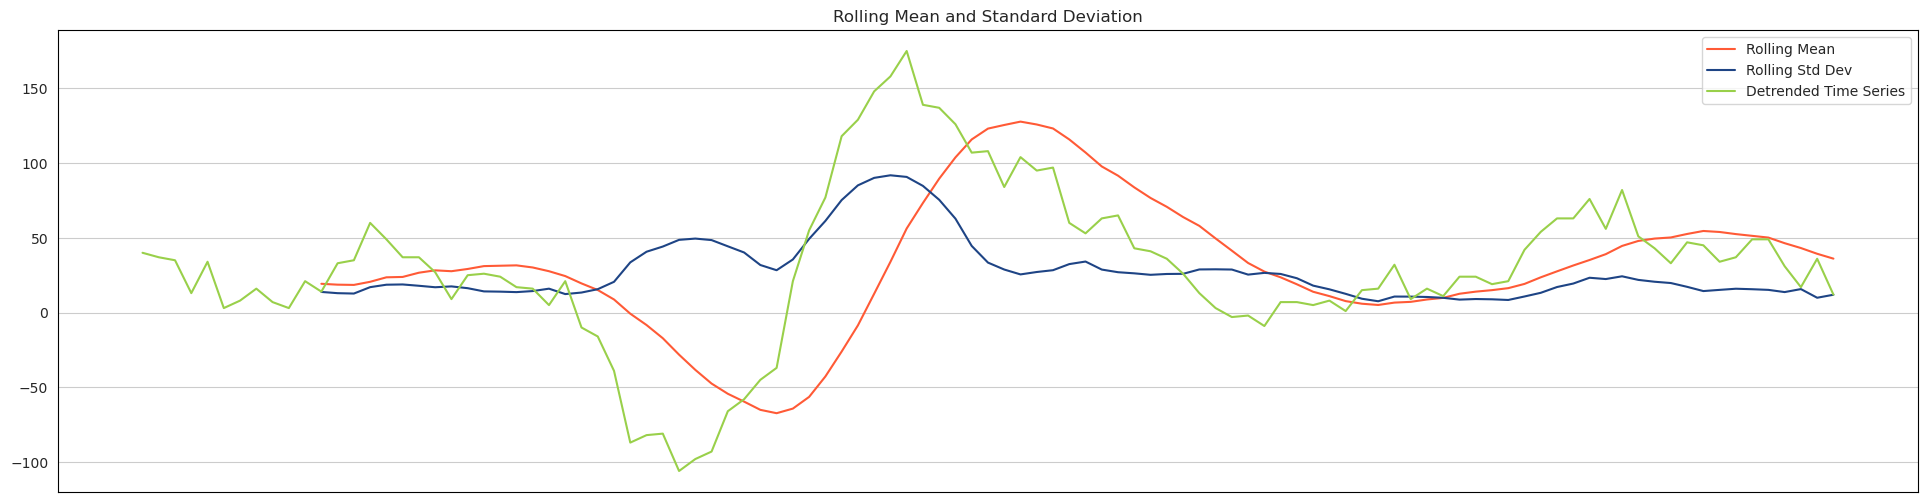

In [27]:
# Test for stationarity 

def stationarity_test(monthly_revenue_detrend):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = monthly_revenue_detrend.rolling(12).mean()
    rolling_std_dev =monthly_revenue_detrend.rolling(12).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(monthly_revenue_detrend, color='#99D04A',label='Detrended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(monthly_revenue_detrend,autolag='AIC') 
    #AIC = Akaike Information Criterion
    #BIC = Bayesian Information Criterion
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(monthly_revenue_detrend, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)

stationarity_test(df_sales['monthly_revenue_detrend'].dropna())

<Axes: title={'center': 'Rolling Mean After Seasonal Differencing'}>

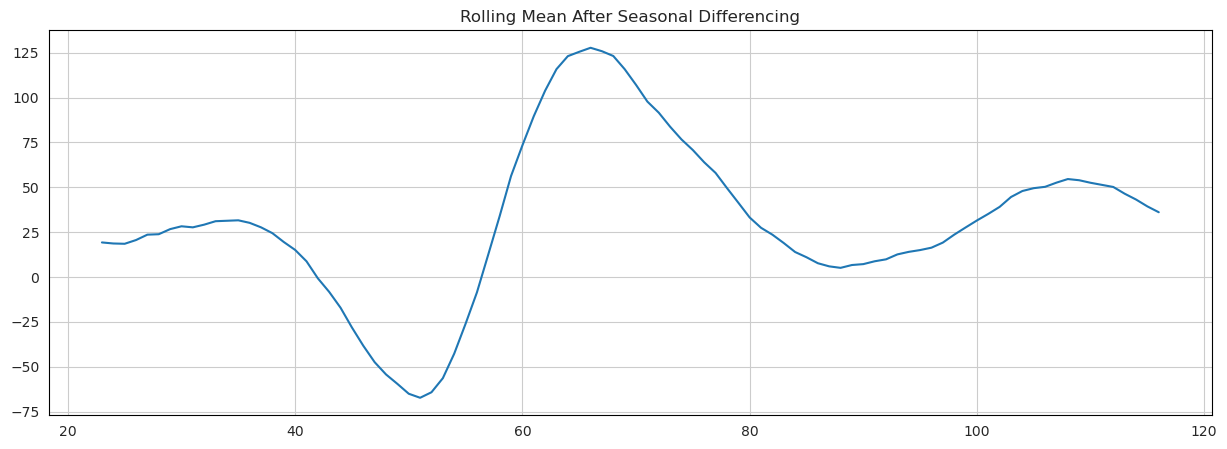

In [31]:
ts = df_sales['monthly_revenue_detrend'].dropna()

rolling_mean = ts.rolling(12).mean()

rolling_mean.plot(title="Rolling Mean After Seasonal Differencing")


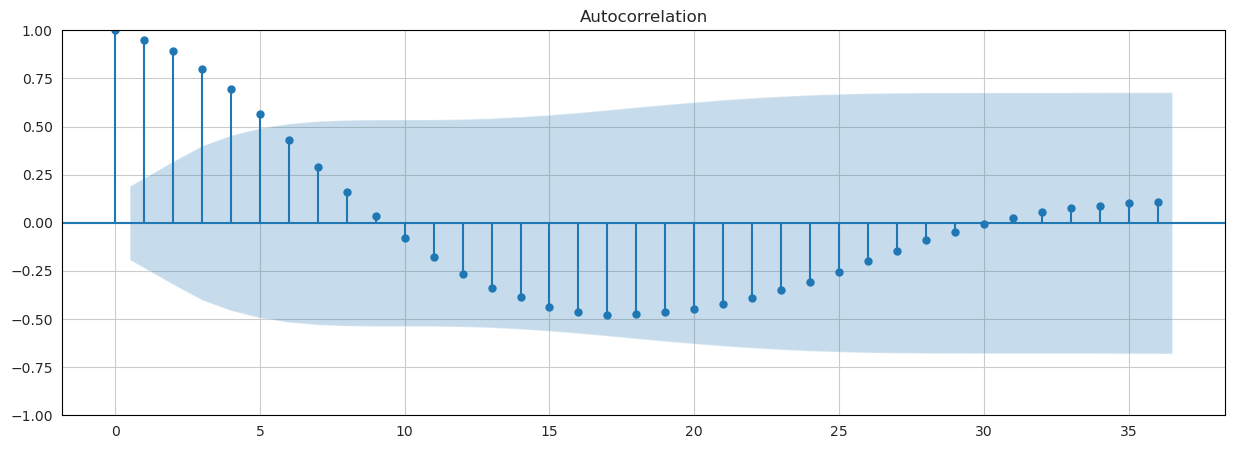

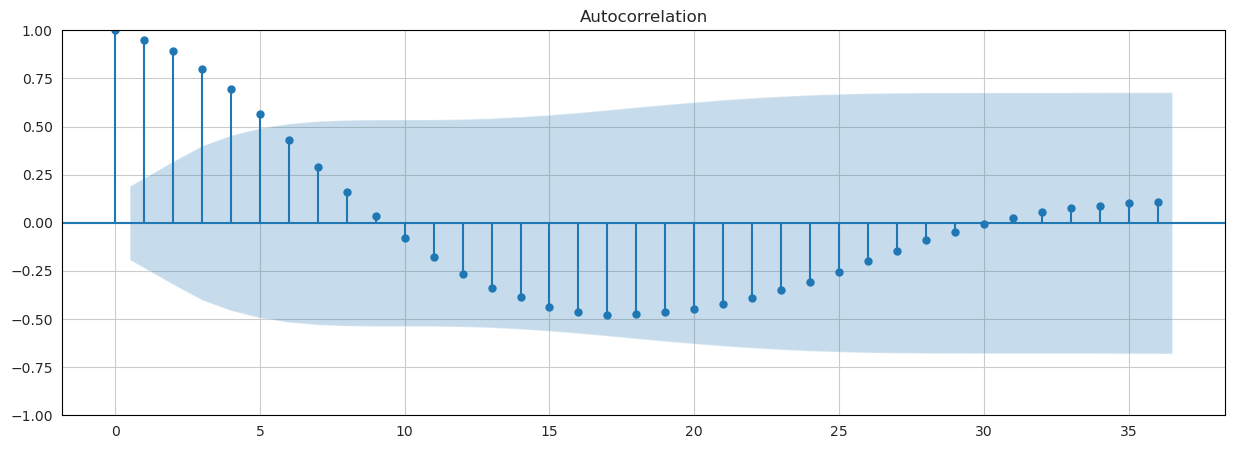

In [30]:
#check seasonality
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_sales['monthly_revenue_detrend'].dropna(), lags=36)


so still seasonality and trend is there after lag=12. correct form lokks like we should take lag=1  as an additional to clear.

In [35]:
df_sales['ts_final'] = df_sales['monthly_revenue'].diff(1).diff(12).dropna()


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -4.888307
p-value: 0.000037
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.051903
p-value: 0.100000
----------------------------------------


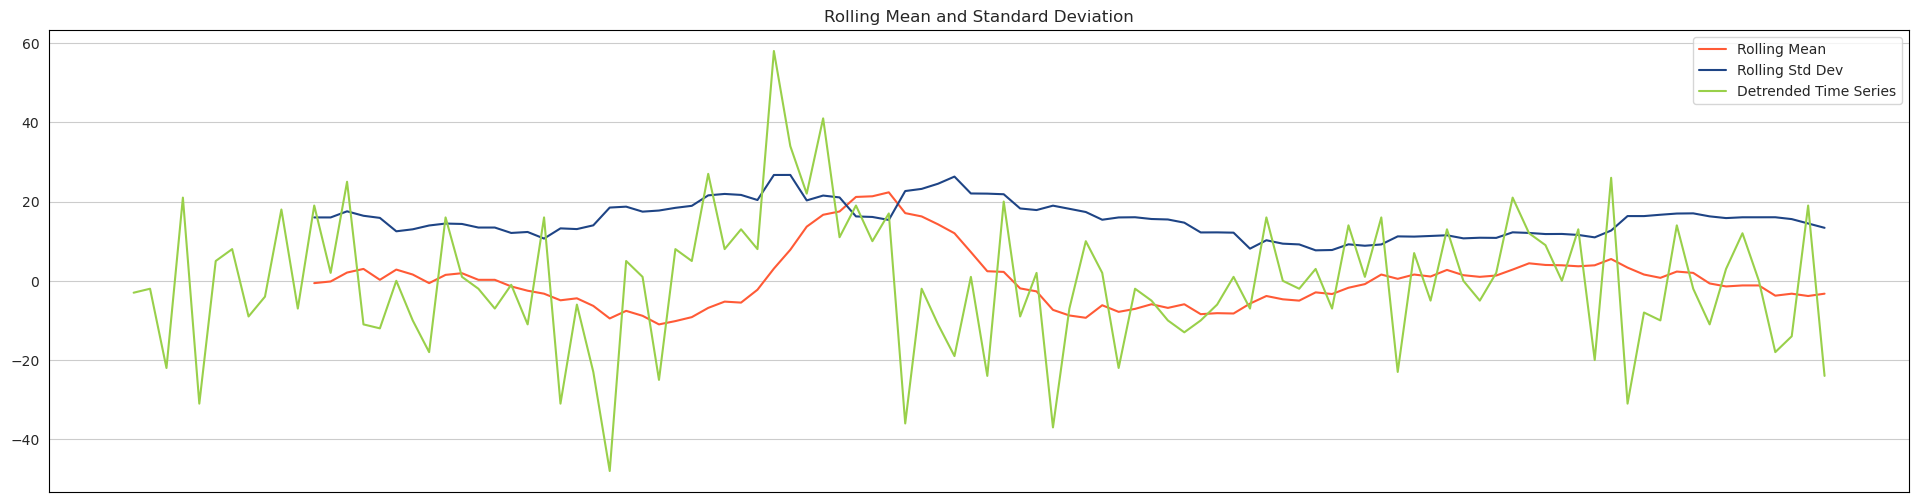

In [36]:
# Test for stationarity 

def stationarity_test(ts_final):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = ts_final.rolling(12).mean()
    rolling_std_dev =ts_final.rolling(12).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(ts_final, color='#99D04A',label='Detrended Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(ts_final,autolag='AIC') 
    #AIC = Akaike Information Criterion
    #BIC = Bayesian Information Criterion
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(ts_final, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)

stationarity_test(df_sales['ts_final'].dropna())
#plt.savefig("visualisations/stationary.png", dpi=300)

### with ts_final (annual (12) lag and additional 1 lag to remove remainin trend and seasonality==>
✔ Trend removed
✔ Seasonality removed
✔ Series is stationary

## Model Building

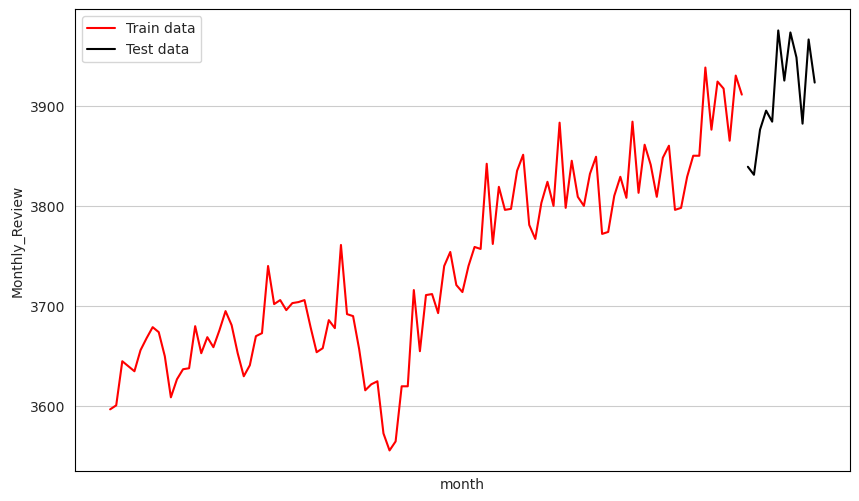

In [41]:
# Split data into train and test set
df_arima = df_sales['monthly_revenue']
train_test_split_ratio = int(len(df_arima)*0.90)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('month')
plt.ylabel('Monthly_Review')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

After splitting the data we can now try to forcast the prices. We can use smoothing methods and ARIMA methods. While smoothing methods can be used for non-stationray data, ARIMA requires the data to be stationary. auto_arima can help us to make the series stationary and determine the optimal order for the ARIMA model.

We will perform multiple fits for each model to find the best hyperparamters. 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=848.939, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1074.199, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=847.108, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=976.467, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1100.108, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=847.454, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=847.199, Time=0.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=847.769, Time=0.27 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=846.322, Time=0.19 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=847.418, Time=0.31 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=849.372, Time=0.67 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=848.321, Time=0.22 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=848.321, Time=0.19 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept 

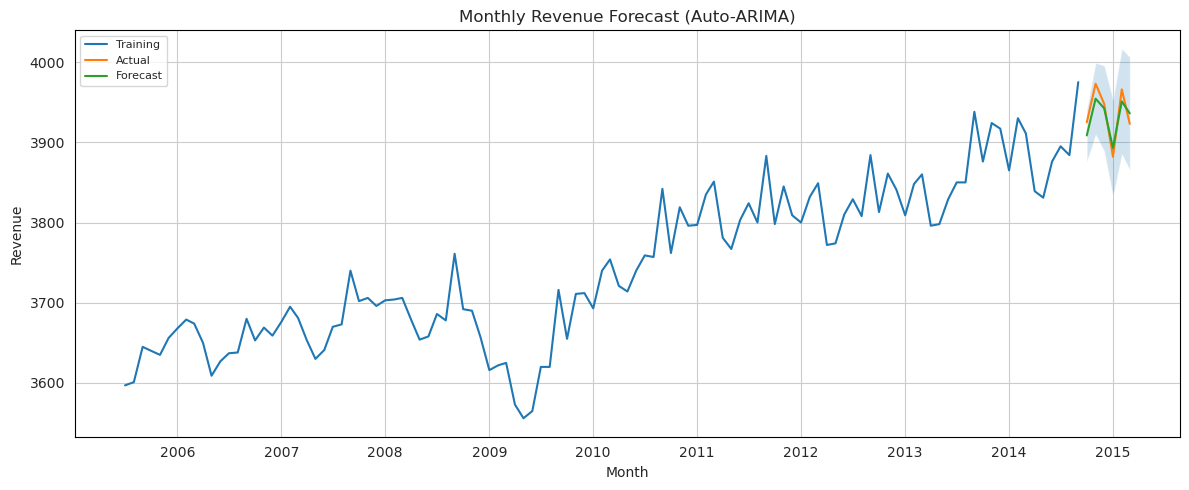

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- 0) Prepare the original monthly series (recommended) ---
# If you already have df_sales with 'month' and 'monthly_revenue':
df_sales["month"] = pd.to_datetime(df_sales["month"])
df_sales = df_sales.sort_values("month")

ts = (
    df_sales
    .set_index("month")["monthly_revenue"]
    .asfreq("MS")  # monthly start frequency
)

# Optional: handle missing months (choose one strategy)
# ts = ts.interpolate()       # if occasional missing months
# ts = ts.fillna(method="ffill")

# --- 1) Train / test split (last 6 months as test) ---
h = 6
train_data = ts.iloc[:-h]
test_data  = ts.iloc[-h:]

# --- 2) Auto ARIMA (Seasonal) ---
arima_model = auto_arima(
    train_data,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    seasonal=True,
    m=12,                  # monthly seasonality
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=None,        # let auto_arima decide differencing
    test='adf',
    trace=True,
    alpha=0.05,
    scoring='mse',
    suppress_warnings=True,
    stepwise=True
)

print(arima_model.summary())

# --- 3) Forecast next 6 months (aligned to test index) ---
forecast_values, conf_int = arima_model.predict(n_periods=h, return_conf_int=True, alpha=0.05)
fcv_series = pd.Series(forecast_values, index=test_data.index, name="forecast")
lower = pd.Series(conf_int[:, 0], index=test_data.index, name="lower_95")
upper = pd.Series(conf_int[:, 1], index=test_data.index, name="upper_95")

# --- 4) Plot ---
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label="Training")
plt.plot(test_data, label="Actual")
plt.plot(fcv_series, label="Forecast")
plt.fill_between(test_data.index, lower, upper, alpha=0.2)
plt.title("Monthly Revenue Forecast (Auto-ARIMA)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend(loc="upper left", fontsize=8)
plt.tight_layout()


# --- 5) Evaluate RMSE on the 6-month holdout ---
rmse = sqrt(mean_squared_error(test_data.values, fcv_series.values))
print("Auto-ARIMA RMSE:", round(rmse, 3))

# save graph
plt.savefig("visualisations/revenue_auto_arima.png", dpi=300)
plt.show()

Auto-ARIMA RMSE: 13.93. revenue level forecast=btw 3800-4000 ==>3900
RMSE=13.93/3900=0.35%. pretty low/good. 

Das Auto-ARIMA-Verfahren identifiziert ein SARIMA(1,0,0)(0,1,1,12)-Modell.
Die saisonale Differenzierung ist notwendig, während keine zusätzliche Trenddifferenzierung erforderlich ist.
Die Residuen zeigen keine signifikante Autokorrelation.
Das Modell liefert eine geringe Prognoseabweichung (RMSE ≈ 14).

For Management(English)

The model captures recurring seasonal effects and short-term revenue persistence.
Forecast accuracy is high, with an average prediction error below 0.5%.
The 6-month outlook indicates continued stable growth within the historical pattern.
